In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf

C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/train_df.csv')
valid_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/valid_df.csv')
test_data  = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/test_df.csv')

In [3]:
def check_dataset(df):
    """
    Функция для проверки адекватности датасета.

    Параметры:
    - df: pandas DataFrame, датасет для проверки.

    Возвращает:
    - Строку с результатами проверки.
    """

    # Проверка наличия дубликатов
    num_duplicates = df.duplicated().sum()

    # Проверка наличия пропущенных значений
    missing_values = df.isnull().sum().sum()

    # Проверка типов данных
    data_types = df.dtypes

    # Проверка наличия уникальных значений в каждом столбце
    unique_values = df.nunique()

    # Проверка распределения значений в категориальных столбцах
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    value_counts_categorical = {col: df[col].value_counts() for col in categorical_columns}

    # Формируем результаты проверки
    results = f"Результаты проверки датасета:\n"\
              f"Количество дубликатов: {num_duplicates}\n"\
              f"Пропущенные значения: {missing_values}\n"\
              f"Типы данных:\n{data_types}\n"\
              f"Уникальные значения:\n{unique_values}\n"\
              f"Распределение значений в категориальных столбцах:\n"
    for col, value_counts in value_counts_categorical.items():
        results += f"Столбец '{col}':\n{value_counts}\n"

    return results

In [4]:
def remove_duplicates_and_missing_values(df):
    """
    Функция для удаления дубликатов и строк с пропущенными значениями из датасета.

    Параметры:
    - df: pandas DataFrame, датасет для обработки.

    Возвращает:
    - Новый DataFrame без дубликатов и строк с пропущенными значениями.
    """
    
    # Удаление дубликатов
    df_no_duplicates = df.drop_duplicates()

    # Удаление строк с пропущенными значениями
    df_no_missing_values = df_no_duplicates.dropna()

    return df_no_missing_values


In [5]:
import re

# Функция для удаления знаков препинания из текста
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Функция для проверки строки на наличие латинских символов
def contains_latin(text):
    return bool(re.search(r'[a-zA-Z]', text))

train_data = remove_duplicates_and_missing_values(train_data)
valid_data = remove_duplicates_and_missing_values(valid_data)
test_data = remove_duplicates_and_missing_values(test_data)


# Удаление знаков препинания из текста
train_data['text'] = train_data['text'].apply(remove_punctuation)
# Приведение текста к нижнему регистру
train_data['text'] = train_data['text'].str.lower()
# Удаление знаков препинания из текста
valid_data['text'] = valid_data['text'].apply(remove_punctuation)
# Приведение текста к нижнему регистру
valid_data['text'] = valid_data['text'].str.lower()
# Удаление знаков препинания из текста
test_data['text'] = test_data['text'].apply(remove_punctuation)
# Приведение текста к нижнему регистру
test_data['text'] = test_data['text'].str.lower()

# Фильтрация строк, содержащих латинские символы
train_data = train_data[~train_data['text'].apply(contains_latin)]
valid_data = valid_data[~valid_data['text'].apply(contains_latin)]
test_data = test_data[~test_data['text'].apply(contains_latin)]

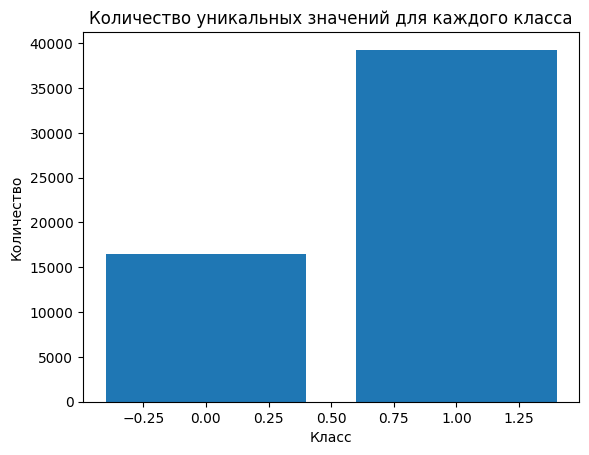

[0.70965442 1.69243851]
{1: 0.7096544171951003, 0: 1.692438505921652}


In [6]:
# Подсчет количества элементов класса_1 и класса_2 в столбце_1
class_counts = train_data['label'].value_counts()

# Построение гистограммы
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Количество уникальных значений для каждого класса')
plt.show()

from sklearn.utils.class_weight import compute_class_weight

# Получение уникальных меток классов
class_labels = train_data['label'].unique()

# Рассчитываем веса классов
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_data['label'])

print(class_weights)

# Создаем словарь с весами классов
class_weight_dict = dict(zip(class_labels, class_weights))

print(class_weight_dict)

In [7]:
tr_text = train_data['text']
tr_label = train_data['label']

val_text = valid_data['text']
val_label = valid_data['label']

ts_text = test_data['text']
ts_label = test_data['label']

In [8]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=512) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=512)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=512)
ts_y = to_categorical(ts_label)

In [9]:
max_words = 20000
max_len = 512
embedding_dim = 32

In [10]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(512, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(512, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(512, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(2, activation='sigmoid')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [11]:
def focal_loss(y_true, y_pred, alpha=0.6, gamma=2):
    epsilon = 1e-9
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
    return tf.reduce_mean(focal_loss)

def f1_score(y_true, y_pred):
    # Округляем предсказанные значения до бинарных (0 или 1)
    y_pred = K.round(y_pred)

    # Ищем True Positives, False Positives и False Negatives
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Вычисляем precision и recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Вычисляем F1 score
    f1_score = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Усредняем F1 score по классам и возвращаем результат
    return K.mean(f1_score)

In [12]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Определение обратного вызова для уменьшения скорости обучения
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Использование:
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy', f1_score])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 512)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 32)      640000      ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 32)      640000      ['embedding_1_input[0][0]']      
                                                                                              

In [13]:
batch_size = 256
epochs = 15
# Обучение модели с использованием обратного вызова
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y),
                    callbacks=[reduce_lr])

Epoch 1/15
218/218 [==============================] - 40s 170ms/step - loss: 0.0872 - accuracy: 0.7811 - f1_score: 0.6708 - val_loss: 0.0950 - val_accuracy: 0.8646 - val_f1_score: 0.8523 - lr: 0.0010
Epoch 2/15
218/218 [==============================] - 37s 170ms/step - loss: 0.0459 - accuracy: 0.8768 - f1_score: 0.8499 - val_loss: 0.0755 - val_accuracy: 0.9026 - val_f1_score: 0.8951 - lr: 0.0010
Epoch 3/15
218/218 [==============================] - 38s 176ms/step - loss: 0.0348 - accuracy: 0.9104 - f1_score: 0.8901 - val_loss: 0.0469 - val_accuracy: 0.9169 - val_f1_score: 0.9117 - lr: 0.0010
Epoch 4/15
218/218 [==============================] - 40s 185ms/step - loss: 0.0258 - accuracy: 0.9341 - f1_score: 0.9193 - val_loss: 0.0333 - val_accuracy: 0.9290 - val_f1_score: 0.9253 - lr: 0.0010
Epoch 5/15
218/218 [==============================] - 41s 189ms/step - loss: 0.0193 - accuracy: 0.9513 - f1_score: 0.9405 - val_loss: 0.0310 - val_accuracy: 0.9228 - val_f1_score: 0.9148 - lr: 0.0010


In [14]:
(loss, accuracy, f1) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, F1: {round(f1, 2)}')

1742/1742 [==============================] - 11s 6ms/step - loss: 0.0019 - accuracy: 0.9958 - f1_score: 0.9834
Loss: 0.0, Accuracy: 1.0, F1: 0.98


In [15]:
(loss, accuracy, f1) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, F1: {round(f1, 2)}')

1/1 [==============================] - 0s 35ms/step - loss: 0.6104 - accuracy: 0.6154 - f1_score: 0.5486
Loss: 0.61, Accuracy: 0.62, F1: 0.55


In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score', 'lr'])

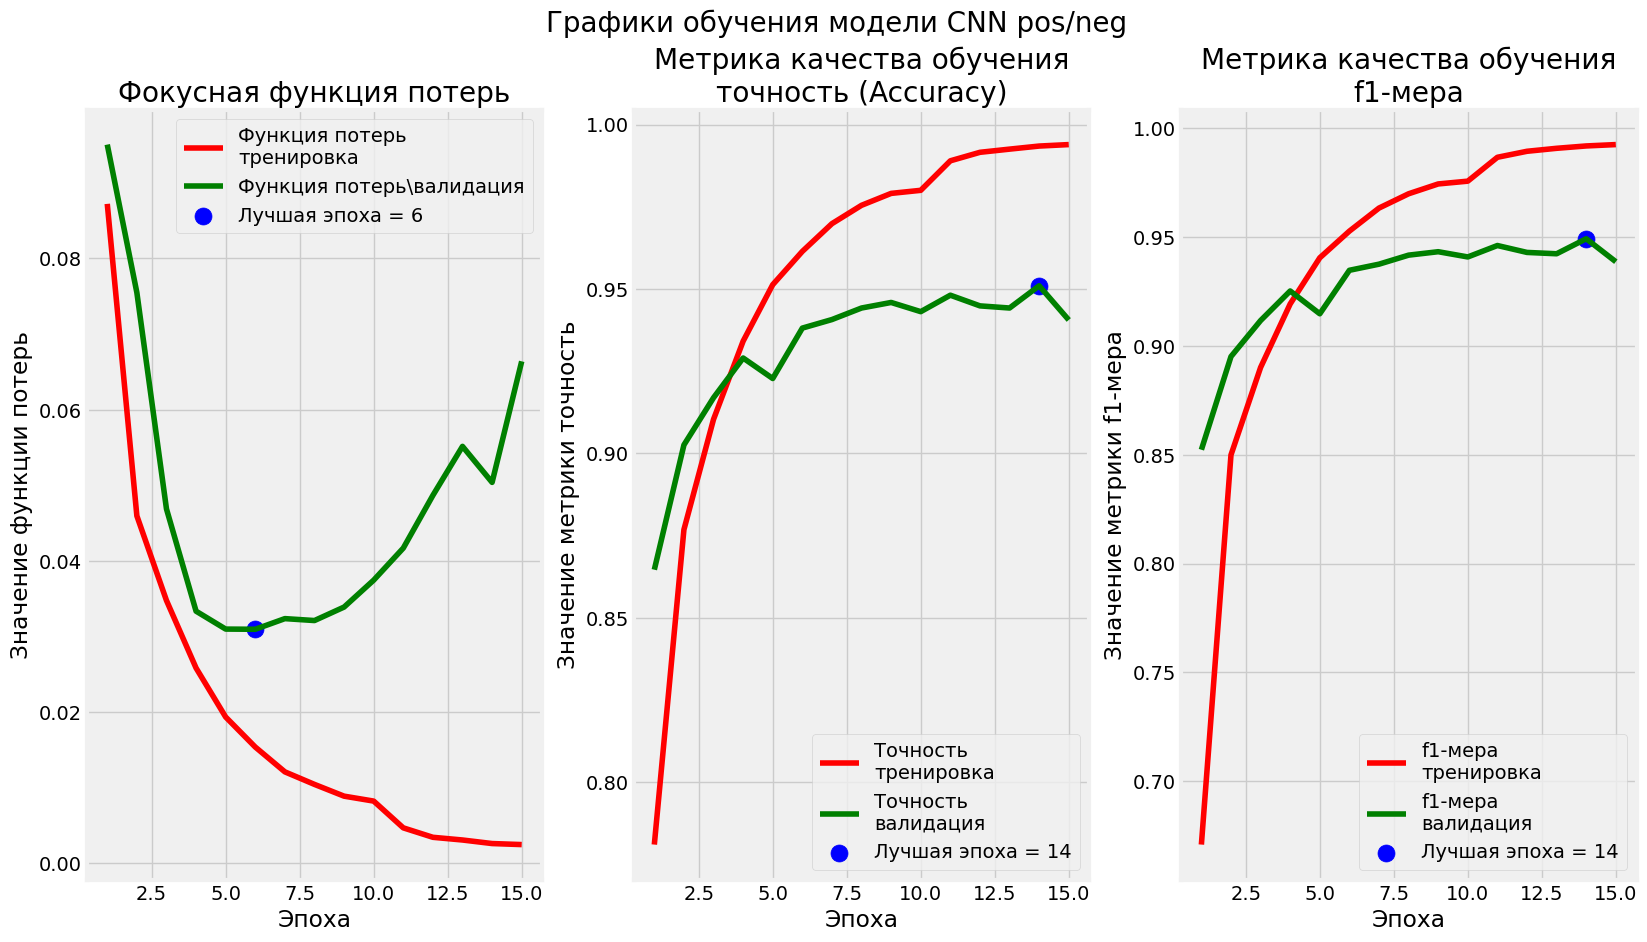

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_f1 = history.history['f1_score']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_f1 = history.history['val_f1_score']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_f1 = np.argmax(val_f1)
f1_highest = val_f1[index_f1]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Лучшая эпоха = {str(index_loss + 1)}'
acc_label = f'Лучшая эпоха = {str(index_acc + 1)}'
f1_label = f'Лучшая эпоха = {str(index_f1 + 1)}'


fig = plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')


plt.subplot(1, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Функция потерь\nтренировка')
plt.plot(Epochs, val_loss, 'g', label='Функция потерь\валидация')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Фокусная функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Точность\nтренировка')
plt.plot(Epochs, val_acc, 'g', label='Точность\nвалидация')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Метрика качества обучения\nточность (Accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(Epochs, tr_f1, 'r', label='f1-мера\nтренировка')
plt.plot(Epochs, val_f1, 'g', label='f1-мера\nвалидация')
plt.scatter(index_f1 + 1, f1_highest, s=150, c='blue', label=f1_label)
plt.title('Метрика качества обучения\nf1-мера')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики f1-мера')
plt.legend()
plt.grid(True)

plt.suptitle('Графики обучения модели CNN pos/neg', fontsize=20)
plt.show()
fig.savefig("plot_train_np", dpi=1000)

In [18]:
y_true=[]
for i in range(len(ts_y)):
    
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [19]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

1/1 [==============================] - 0s 126ms/step


array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0], dtype=int64)

<Axes: >

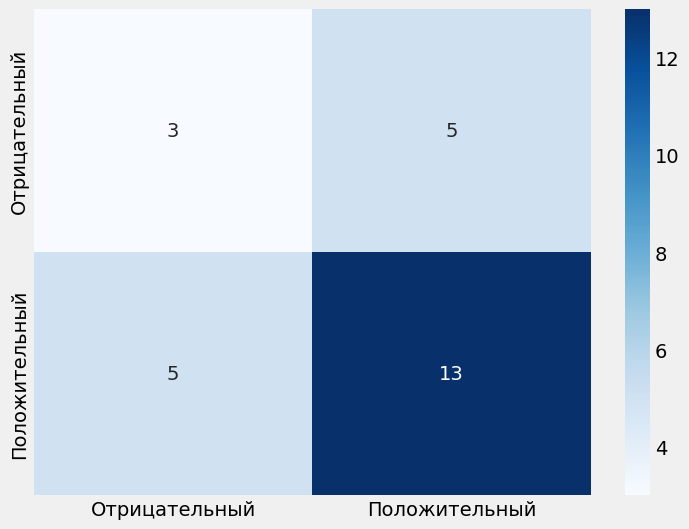

In [20]:
fig = plt.figure(figsize=(8,6))
emotions = {0: 'Отрицательный', 1: 'Положительный'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
# fig.savefig("conf_matrix", dpi=1000)

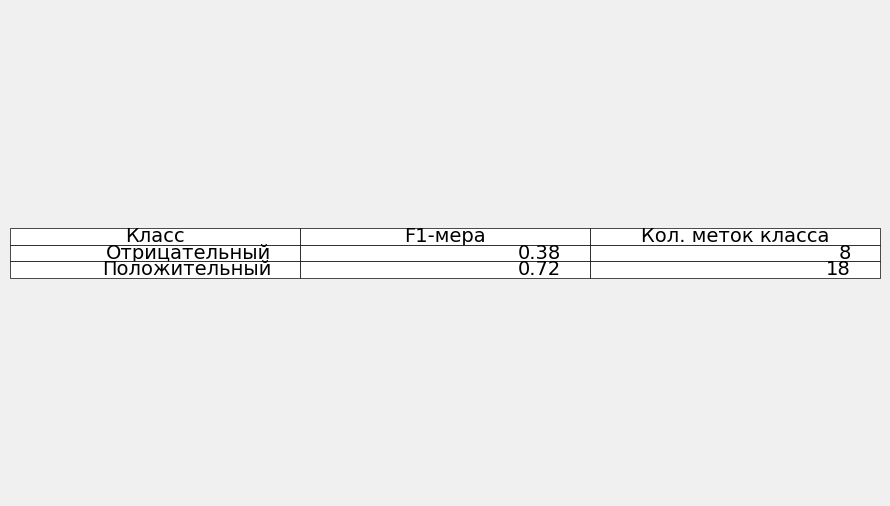

In [21]:
clr = classification_report(y_true, y_pred)

# Преобразование текста отчета о классификации в массив NumPy
report_data = []
report_lines = clr.split('\n')
for line in report_lines[2:-5]:  # Игнорируем первые две строки заголовка и последние пять строк с общими показателями
    row_data = line.split()
    # Замена значений классов 0 и 1 на "negative" и "positive"
    if row_data[0] == '0':
        row_data[0] = 'Отрицательный'
    elif row_data[0] == '1':
        row_data[0] = 'Положительный'
    row_data = [row_data[0], row_data[3], row_data[4]]  # Пропускаем столбцы Precision и Recall
    report_data.append(row_data)

# Создание таблицы matplotlib
fig, ax = plt.subplots(figsize=(10, 6))  # Установка размеров рисунка
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_data, loc='center', colLabels=['Класс', 'F1-мера', 'Кол. меток класса'])

# Сохранение рисунка
# plt.savefig('classification_report.png', dpi=1000)  # Сохранить в виде изображения
plt.show()

In [22]:
import pickle
with open('tokenizer_np.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp_np.h5')

In [23]:
def load_model_with_focal_loss(model_path):
    custom_objects = {'focal_loss': focal_loss, 'f1_score': f1_score}  # Добавляем пользовательскую функцию потерь в custom_objects
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    return model

In [24]:
import numpy as np

# Функция predict остается неизменной, но при вызове используется numpy.argmax для определения предсказанного класса

def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences(text)
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    # Использование numpy.argmax для определения предсказанного класса
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predicted_labels

# Загрузка данных test_data и их предсказание
texts = list(test_data['text'])
labels = list(test_data['label'])

predicted_labels = predict(texts, 'nlp_np.h5', 'tokenizer_np.pkl')

# Вызов функции precision_recall_fscore_support с обновленными labels и predicted_labels
from sklearn.metrics import precision_recall_fscore_support

_, _, f1score, _ = precision_recall_fscore_support(labels, predicted_labels, average='micro')

print(f'f1score: {f1score}')

df = pd.DataFrame()
df = test_data
df['predict'] = predicted_labels
df

1/1 [==============================] - 0s 103ms/step
f1score: 0.6153846153846154


,text,label,predict
6,основы программирования лектор имел забавную п...,0,0
11,основы программирования ясное и чёткое объясне...,1,1
12,продвинутые техники программирования на вебина...,0,1
13,продвинутые техники программирования подробный...,1,1
21,управление персоналом все понравилось календар...,0,0
29,основы программирования дискуссия о том как пи...,0,1
31,продвинутые техники программирования сессия по...,1,1
32,продвинутые техники программирования затронута...,1,0
33,основы программирования отличное объяснение те...,1,1
34,продвинутые техники программирования разбор пр...,1,1


In [25]:
def predict1(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    emotions = {0: 'Отрицательный', 1: 'Положительный'}
    
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Вероятность принадлежности классу', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 0s 104ms/step


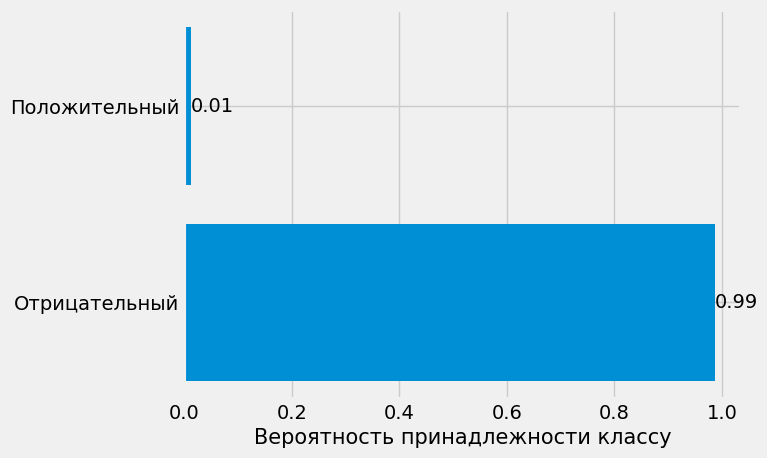

In [26]:
txt = 'о да не существуют проблемы этот курс подходит для меня'
predict1(txt, 'nlp_np.h5', 'tokenizer_np.pkl')

In [27]:
import numpy as np

test_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/test_df.csv')

# Функция predict остается неизменной, но при вызове используется numpy.argmax для определения предсказанного класса

def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences(text)
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    # Использование numpy.argmax для определения предсказанного класса
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predicted_labels

# Загрузка данных test_data и их предсказание
texts = list(test_data['text'])
labels = list(test_data['label'])

predicted_labels = predict(texts, 'nlp_np.h5', 'tokenizer_np.pkl')

y_true=[]
for i in range(len(labels)):

    y_true.append(labels[i])
    
y_pred = predicted_labels

# Вызов функции precision_recall_fscore_support с обновленными labels и predicted_labels
from sklearn.metrics import precision_recall_fscore_support

_, _, f1score, _ = precision_recall_fscore_support(labels, predicted_labels, average='micro')

print(f'f1score: {f1score}')

df = pd.DataFrame()
df = test_data
df['predict'] = predicted_labels
df

4/4 [==============================] - 0s 9ms/step
f1score: 0.7281553398058251


,text,label,predict
0,основы программирования интерактивный подход к...,1,1
1,основы программирования подробное объяснение л...,1,1
2,основы программирования введение в программиро...,1,1
3,основы программирования понятное изложение осн...,1,1
4,основы программирования кларность и структура ...,1,0
...,...,...,...
98,основы программирования преподователь раз тако...,1,0
99,новейшие тенденции в it очень понравилось изуч...,1,1
100,новейшие тенденции в it очень подробный разбор...,0,1
101,java api браузеров понравилась тема да преподо...,0,1


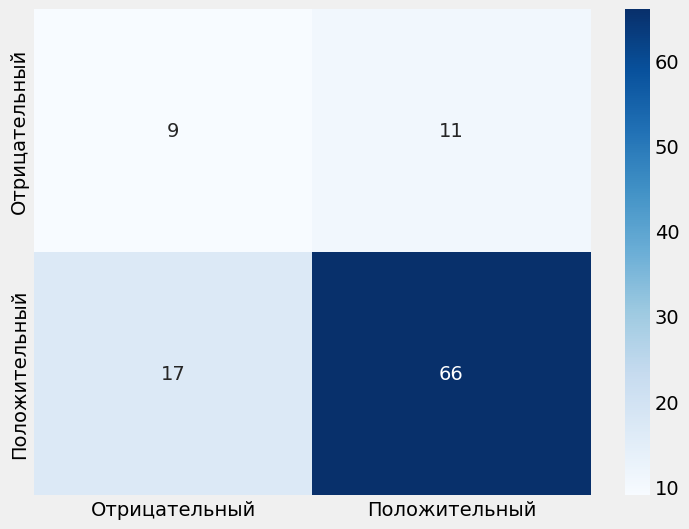

In [28]:
fig = plt.figure(figsize=(8,6))
emotions = {0: 'Отрицательный', 1: 'Положительный'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
fig.savefig("conf_matrix_np.png", dpi=1000)

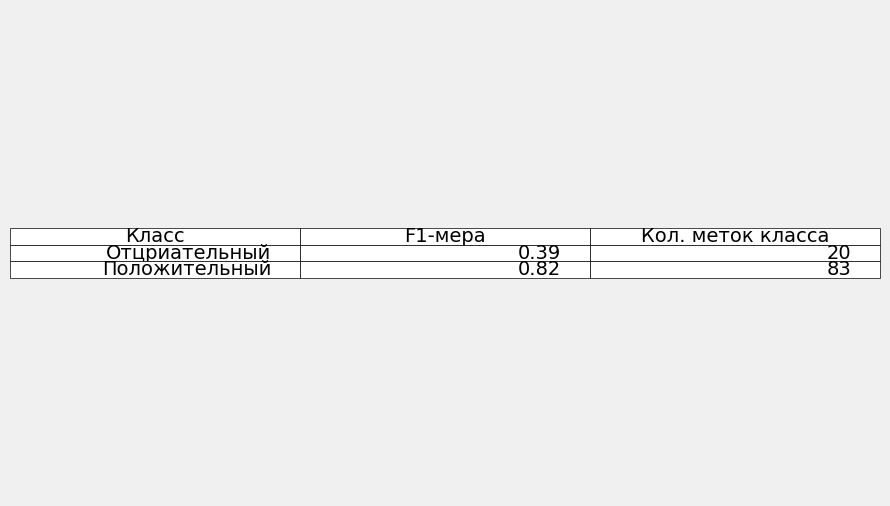

In [29]:
clr = classification_report(y_true, y_pred)

# Преобразование текста отчета о классификации в массив NumPy
report_data = []
report_lines = clr.split('\n')
for line in report_lines[2:-5]:  # Игнорируем первые две строки заголовка и последние пять строк с общими показателями
    row_data = line.split()
    # Замена значений классов 0 и 1 на "negative" и "positive"
    if row_data[0] == '0':
        row_data[0] = 'Отцриательный'
    elif row_data[0] == '1':
        row_data[0] = 'Положительный'
    row_data = [row_data[0], row_data[3], row_data[4]]  # Пропускаем столбцы Precision и Recall
    report_data.append(row_data)

# Создание таблицы matplotlib
fig, ax = plt.subplots(figsize=(10, 6))  # Установка размеров рисунка
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_data, loc='center', colLabels=['Класс', 'F1-мера', 'Кол. меток класса'])

# Сохранение рисунка
plt.savefig('classification_report_np.png', dpi=1000)  # Сохранить в виде изображения
plt.show()